In [1]:
library(devtools)
#devtools::load_all("~/TedSim/TedSim_1.00/TedSim")
library(TedSim)
library(dplyr)
library(Seurat)
library(ggplot2)
library(reshape2)
library(ctc)
library(ape)
#
library(dichromat)
library(scales)

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: amap



In [2]:
ncells <- 1024
phyla <- read.tree(text='((t1:3, (t2:2, t3:2):1):1);')
#phyla <- read.tree(text='((t1:2, t2:2):1, (t3:2, t4:2):1):2;')
#phyla <- read.tree(text='((t1:2, t2:2):1);')
N_nodes <- 2*ncells-2
ngenes <- 500
max_walk <- 6
p_a <- 0.6
n_cif <- 30
n_diff <- 20
cif_step <- 0.25
p_d <- 0
mu <- 0.1
N_char <- 32
unif_on <- FALSE
set.seed(233)

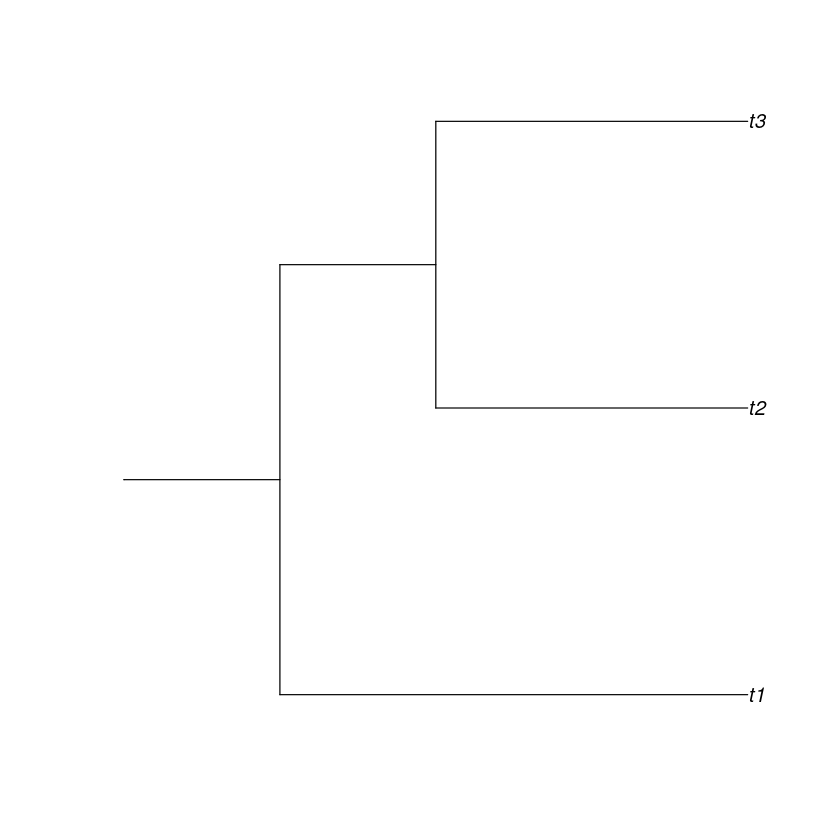

In [3]:
plot(phyla)

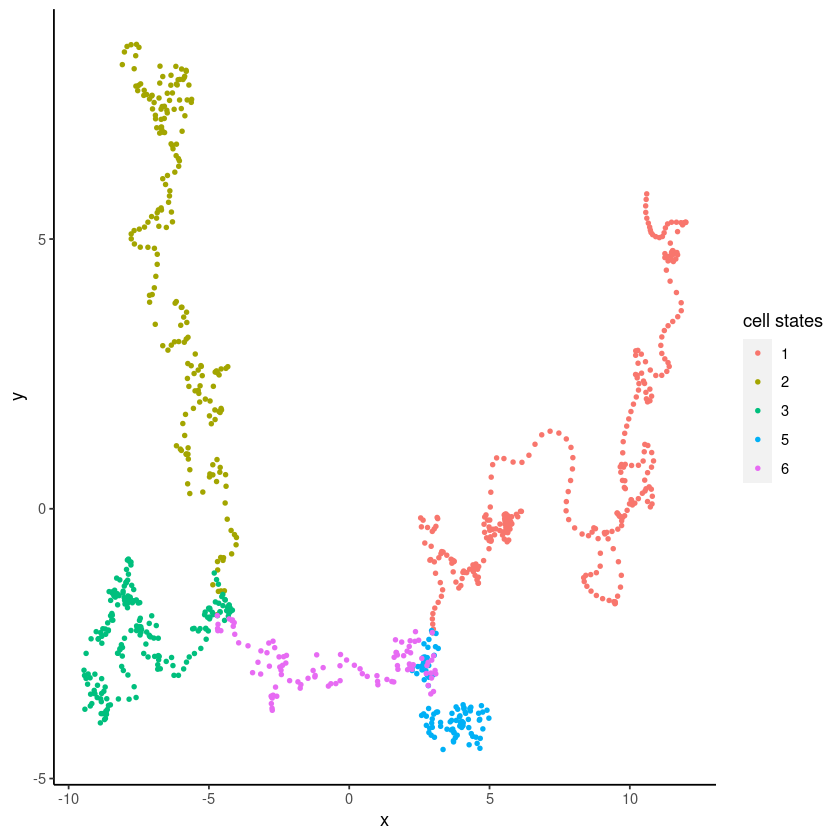

In [4]:
returnlist <- SIFGenerate(phyla, n_diff, step = cif_step)
sif_mean_raw <- returnlist$sif_mean_raw
sif_label <- sif_mean_raw[[1]][,2]
sif_mean_raw <- lapply(sif_mean_raw,function(X){
  X[,4]
})
sif_mean_raw <- do.call(cbind,sif_mean_raw)
sif_pca <- prcomp(sif_mean_raw)
plot_pca <- data.frame(label=sif_label,x=sif_pca$x[,1],y=sif_pca$x[,2])
p <- ggplot(plot_pca, aes(x, y))
p <- p + geom_point(aes(colour = factor(label)),shape=20) + labs(color='cell states')
p <- p+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
             panel.background = element_blank(), axis.line = element_line(colour = "black"))
p

In [5]:
cifs <- SimulateCIFs(ncells,phyla,p_a = p_a,n_CIF = n_cif,n_diff = n_diff,
                     step = cif_step, p_d = p_d, mu = mu,
                     Sigma = 0.5, N_char = N_char,
                     max_walk = max_walk, SIF_res = returnlist, unif_on = unif_on)
#We only need the leaf cells for experiments
cif_leaves <- lapply(c(1:3),function(parami){
  cif_leaves_all <- cifs[[1]][[parami]][c(1:ncells),]
  return(cif_leaves_all)
})
cif_res <- list(cif_leaves,cifs[[2]])
states <- cifs[[2]]
states <- states[1:N_nodes,]
states_leaves <- states[1:ncells,]
muts <- cifs[[7]]
rownames(muts) <- paste("cell",states[,4],sep = "_")
muts_leaves <- muts[1:ncells,]

In [6]:
#simulate true counts
true_counts_res <- CIF2Truecounts(ngenes = ngenes, ncif = n_cif,
                                  ge_prob = 0.3,ncells = N_nodes, cif_res = cifs)

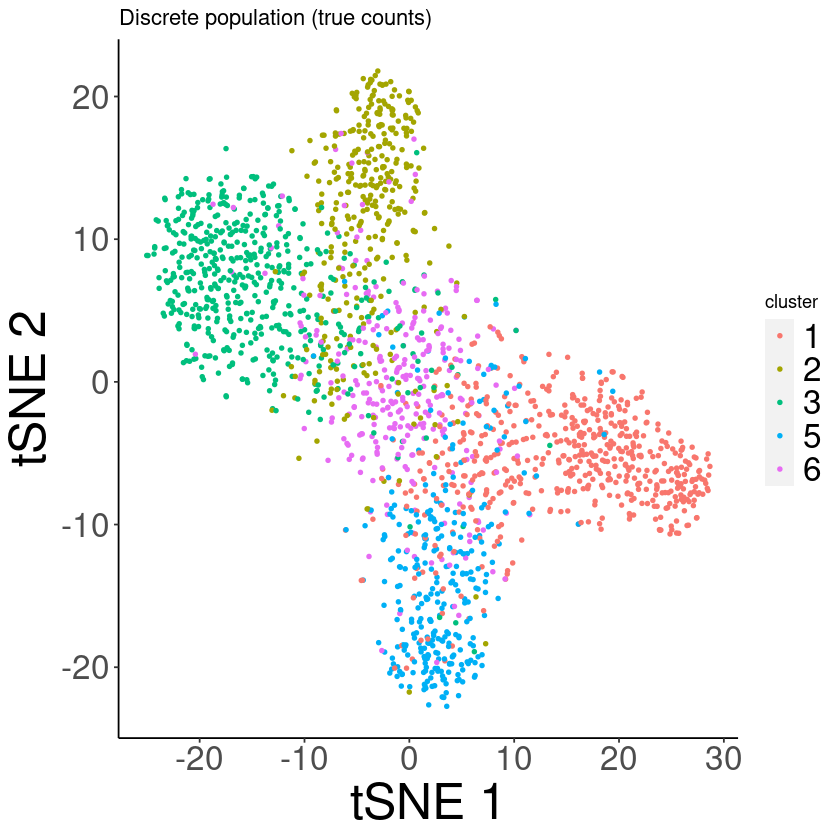

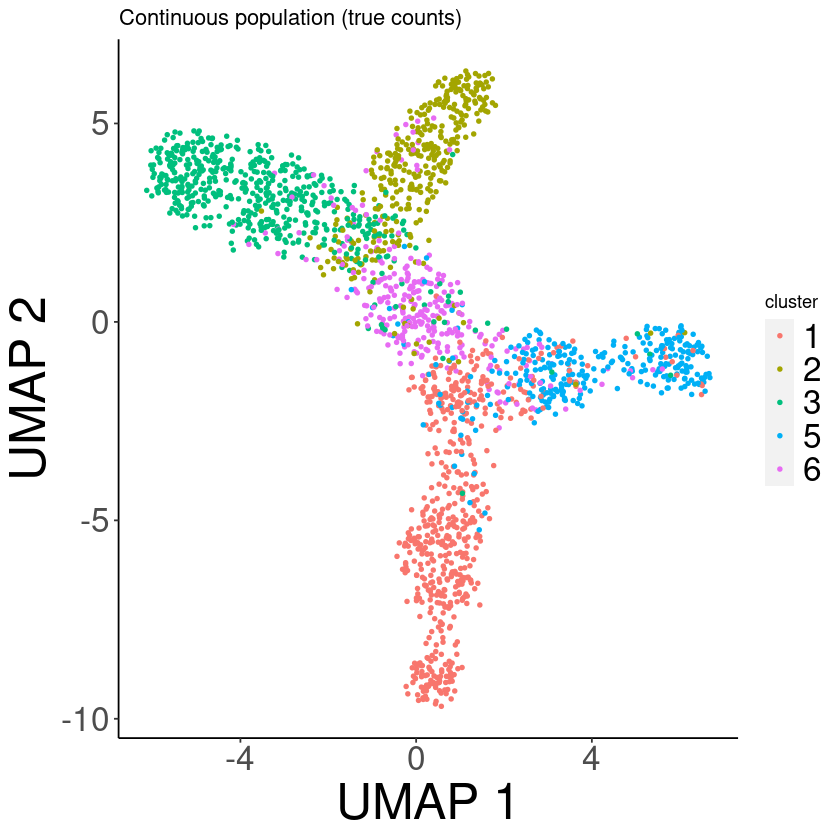

In [7]:
tsne_true_counts <- PlotTsne(meta=states, data=log2(true_counts_res[[1]]+1), cif_type="continuous", n_pc=30, label='cluster', saving = F, plotname="Discrete population (true counts)")
umap_true_counts <- PlotUmap(meta=states, data=log2(true_counts_res[[1]]+1), n_pc=30, label='cluster', saving = F, plotname="Differentiating population (true counts)")
tsne_true_counts[[2]] + ggtitle("Discrete population (true counts)") + xlab("tSNE 1") + ylab("tSNE 2") +  theme(axis.text = element_text(size = 20), axis.title = element_text(size = 30),legend.text = element_text(size = 20))
umap_true_counts[[2]] + ggtitle("Continuous population (true counts)") + xlab("UMAP 1") + ylab("UMAP 2") +  theme(axis.text = element_text(size = 20), axis.title = element_text(size = 30),legend.text = element_text(size = 20))

In [8]:
data(gene_len_pool)
gene_len <- sample(gene_len_pool, ngenes, replace = FALSE)
observed_counts <- True2ObservedCounts(true_counts=true_counts_res[[1]], meta_cell=true_counts_res[[3]],
                                       protocol="UMI", alpha_mean=0.2,
                                       alpha_sd=0.05, gene_len=gene_len, depth_mean=1e5, depth_sd=3e3)

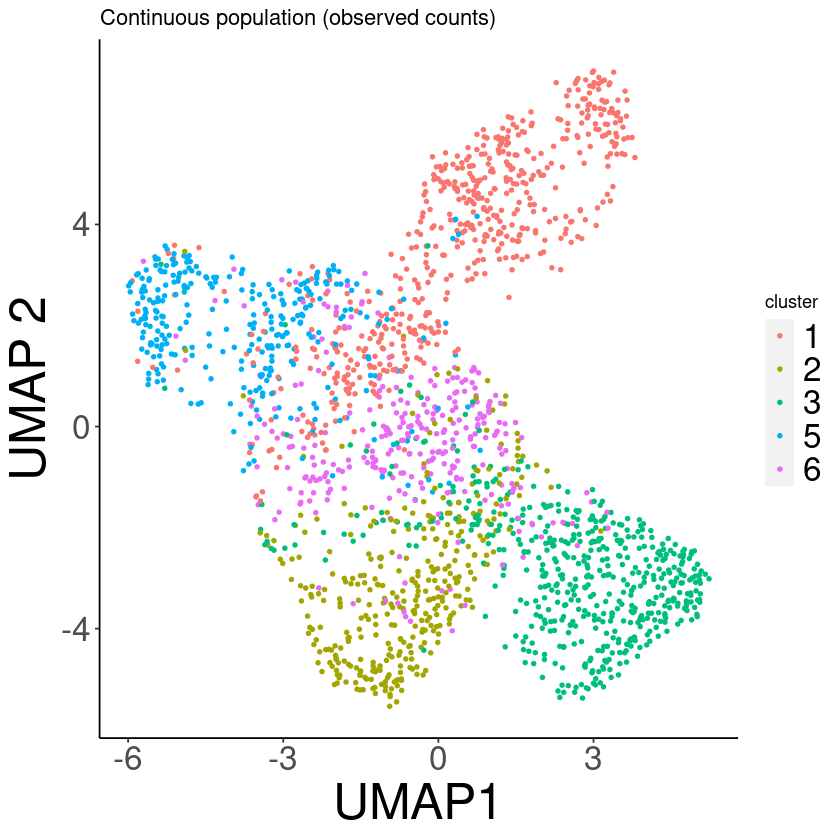

In [9]:
umap_UMI_counts <- PlotUmap(meta=states, data=log2(observed_counts[[1]]+1), n_pc=30, label='cluster', saving = F, plotname="Differentiating population (observed counts)")
umap_UMI_counts[[2]] + ggtitle("Continuous population (observed counts)") + xlab("UMAP1") + ylab("UMAP 2") +  theme(axis.text = element_text(size = 20), axis.title = element_text(size = 30),legend.text = element_text(size = 20))

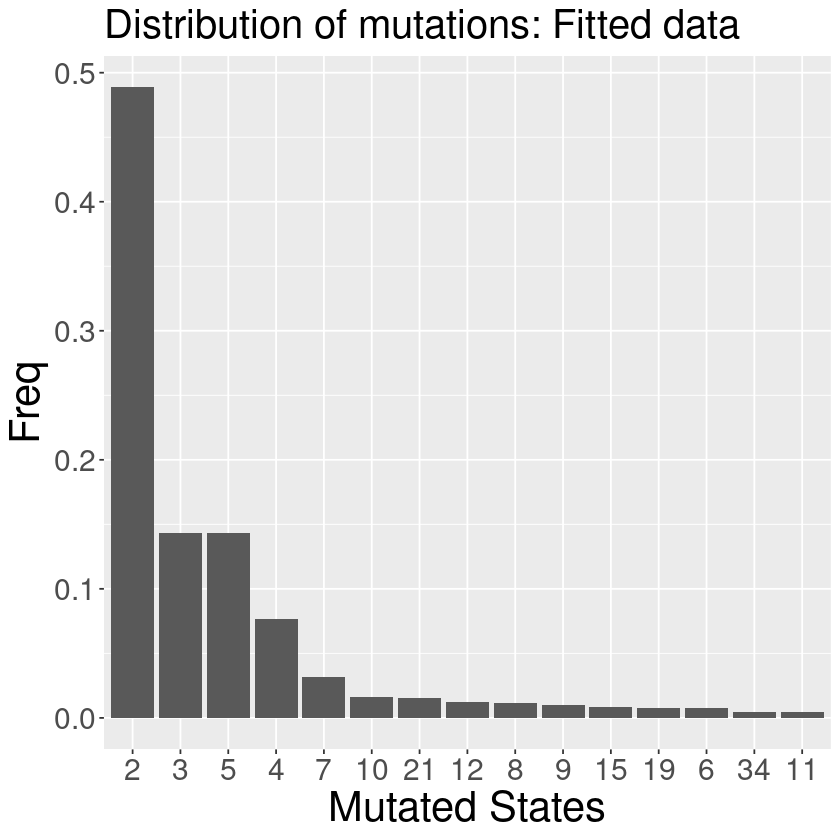

In [10]:
muts_table <- table(unlist(muts))
muts_table <- muts_table[dimnames(muts_table)[[1]]!='0']
muts_table <- muts_table[dimnames(muts_table)[[1]]!='-']
muts_prop <- prop.table(sort(muts_table,decreasing = TRUE))
muts_prop <- muts_prop[1:15]
df_prop <- as.data.frame(muts_prop)
p <- ggplot(df_prop) + geom_col(aes(x = Var1,y = Freq))
p <- p + ggtitle("Distribution of mutations: Fitted data") +
  xlab("Mutated States") + ylab("Freq")
p + theme(title =element_text(size=20),axis.text = element_text(size = 18), axis.title = element_text(size = 25))

In [11]:
gene_expression_dir <- "./output_f/counts_tedsim_pa0.75_step0.25.csv"
cell_meta_dir <- "./output_f/cell_meta_tedsim_pa0.75_step0.25.csv"
character_matrix_dir <- "./output_f/character_matrix_pd0.txt"
combined_profile_dir <- "./output_f/profile_c_tedsim.txt"
top_genes_dir <- "./output_f/top_genes_tedsim.txt"
tree_gt_dir <- "./output_f/tree_gt_bin_tedsim_pd0.newick"
write.tree(cifs[[4]],tree_gt_dir)
write.csv(observed_counts[[1]],gene_expression_dir,row.names = FALSE)
write.csv(states,cell_meta_dir)
write.table(muts,character_matrix_dir)

In [12]:
if (FALSE) {
    muts_ <- CaptureDrop(observed_counts[[1]],muts)
    profile_res <- Generate_profile_multi(observed_counts,muts,states)
    profile_out <- profile_res[[1]]
    top_genes <- profile_res[[2]]
    write.table(profile_out,file = combined_profile_dir,row.names = FALSE,sep = "\t", quote = FALSE)
    write.table(subset(top_genes,select = 1),top_genes_dir,row.names = FALSE,sep = "\t", quote = FALSE)
}